Hackathon - Fase 5

* Carlos Eduardo Oliveira Possoni
* Gabriel Ferreira da Silva Pinto
* Mariana Barbalho Belo da Silva
* Mateus Resende da Silva


**Base de dados utilizada:**  
https://drive.google.com/drive/folders/1f3jtTRyOK-PBvND3JTPTAxHpnSrH7rFR

**Data do Último Acesso:**  
Setembro/2025


## Descrição do Projeto

Este projeto implementa um sistema de recomendação que avalia a aderência de um candidato às vagas em aberto, com base nas exigências de cada vaga.  
O objetivo é fornecer uma pontuação de compatibilidade entre candidatos e vagas, ajudando a equipe de RH a identificar os candidatos mais alinhados às oportunidades disponíveis.

O modelo utiliza NLP (Processamento de Linguagem Natural) e embeddings pré-treinados do Sentence-BERT para calcular a similaridade semântica entre currículos e descrições de vagas.


In [2]:
# Instalação e configuração da biblioteca spaCy para processamento de linguagem natural em português
!pip install spacy

# Baixa e instala o modelo de linguagem em português (pt_core_news_sm)
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 102.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
## Importação de bibliotecas necessárias

# Utilitários do sistema
import sys

# Exportação e serialização de modelos/embeddings
import pickle

# Manipulação e análise de dados
import pandas as pd
import numpy as np

# Visualização de dados
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Processamento de linguagem natural e pré-processamento de texto
import nltk
import re
import string
import unicodedata
import sklearn
import spacy
import sentence_transformers
import torch

# Funcionalidades específicas do NLTK
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Funções do Scikit-Learn
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Sentence-Transformers para embeddings semânticos
from sentence_transformers import SentenceTransformer, util


# Download de recursos do NLTK
nltk.download("stopwords")
nltk.download("punkt_tab")

# Definição de stopwords em português
stop_words = nltk.corpus.stopwords.words('portuguese')

# Carregamento do modelo spaCy em português
nlp = spacy.load("pt_core_news_sm")

# Definição de uma SEED para garantir reprodutibilidade
SEED = 42

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [4]:
## Verificação das versões do ambiente e bibliotecas utilizadas

# Versão do Python
print(f"'Python'                - Versão: '{sys.version.split()[0]}'")

# Versões principais das bibliotecas de análise de dados e PLN
print(f"'pandas'                - Versão: '{pd.__version__}'")
print(f"'numpy'                 - Versão: '{np.__version__}'")
print(f"'matplotlib'            - Versão: '{matplotlib.__version__}'")
print(f"'seaborn'               - Versão: '{sns.__version__}'")
print(f"'nltk'                  - Versão: '{nltk.__version__}'")
print(f"'scikit-learn'          - Versão: '{sklearn.__version__}'")
print(f"'spacy'                 - Versão: '{spacy.__version__}'")
print(f"'torch'                 - Versão: '{torch.__version__}'")
print(f"'sentence-transformers' - Versão: '{sentence_transformers.__version__}'")

# Versão do modelo pré-treinado do spaCy em português
nlp = spacy.load("pt_core_news_sm")
print(f"'pt_core_news_sm'       - Versão: '{nlp.meta['version']}'")

'Python'                - Versão: '3.12.11'
'pandas'                - Versão: '2.2.2'
'numpy'                 - Versão: '2.0.2'
'matplotlib'            - Versão: '3.10.0'
'seaborn'               - Versão: '0.13.2'
'nltk'                  - Versão: '3.9.1'
'scikit-learn'          - Versão: '1.6.1'
'spacy'                 - Versão: '3.8.7'
'torch'                 - Versão: '2.8.0+cu126'
'sentence-transformers' - Versão: '5.1.0'
'pt_core_news_sm'       - Versão: '3.8.0'


In [5]:
## Carregamento e pré-processamento da base de candidatos

# Lê o arquivo JSON e organiza em DataFrame
df = pd.read_json('/content/applicants.json', orient='index')

# Extrai o campo 'codigo_profissional' de 'infos_basicas'
df['codigo_profissional'] = df['infos_basicas'].apply(lambda x: x.get('codigo_profissional', None))

# Mantém apenas as colunas relevantes: currículo (cv_pt) e código profissional
df = df[['cv_pt', 'codigo_profissional']]

# Remove linhas com valores nulos
df = df.dropna()

# Remove linhas que possuem valores vazios ("") em qualquer coluna
df = df[df.ne('').all(axis=1)]

# Reseta o índice após a limpeza
df = df.reset_index(drop=True)

# Visualiza as primeiras linhas do DataFrame
df.head()

,cv_pt,codigo_profissional
0,assistente administrativo\n\n\nsantosbatista\n...,31000
1,formação acadêmica\nensino médio (2º grau) em ...,31001
2,objetivo: área administrativa | financeira\n\n...,31002
3,formação\nensino médio completo\ninformática i...,31003
4,última atualização em 09/11/2021\n­ sp\n\nensi...,31004


In [6]:
## Funções para tratamento e pré-processamento de textos

# Normaliza os acentos, convertendo caracteres acentuados para a forma básica
def normalizar_acentos(texto):
    return unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8')

# Remove pontuações do texto e substitui por espaços
def remover_pontuacao(text):
    punctuations = string.punctuation
    table = str.maketrans({key: ' ' for key in punctuations})
    text = text.translate(table)
    text = re.sub(r'\s+', ' ', text)  # remove múltiplos espaços
    return text

# Normaliza o texto aplicando:
# - letras minúsculas
# - remoção de pontuação
# - remoção de acentos
# - limpeza de espaços extras
def normalizar_texto(texto):
    texto = texto.lower()
    texto = remover_pontuacao(texto)
    texto = normalizar_acentos(texto)
    texto = re.sub(r' +', ' ', texto)
    return ' '.join([w for w in texto.split()])

# Tokeniza e lematiza o texto em português com spaCy, removendo stopwords e pontuações
def tokenizar(texto):
    stop_words = nltk.corpus.stopwords.words('portuguese')
    if isinstance(texto, str):
        texto = normalizar_texto(texto)
        doc = nlp(texto)

        tokens = [
            token.lemma_
            for token in doc
            if token.lemma_ not in stop_words and not token.is_punct
        ]
        return ' '.join(tokens)
    else:
        return None

In [7]:
## Carregamento e organização da base de vagas

# Lê o arquivo JSON de vagas e redefine o índice
df_vagas = pd.read_json('vagas.json', orient='index').reset_index()
df_vagas.rename(columns={'index': 'id_vaga'}, inplace=True)

# Normaliza colunas aninhadas (expande os dicionários em colunas individuais)
df_info_basicas = pd.json_normalize(df_vagas['informacoes_basicas'])
df_perfil_vaga = pd.json_normalize(df_vagas['perfil_vaga'])
df_beneficios = pd.json_normalize(df_vagas['beneficios'])

# Concatena todas as informações em um único DataFrame
df_vagas = pd.concat(
    [df_vagas[['id_vaga']], df_info_basicas, df_perfil_vaga, df_beneficios],
    axis=1
)

# Exibe as primeiras linhas da base estruturada
df_vagas.head()

,id_vaga,data_requicisao,limite_esperado_para_contratacao,titulo_vaga,vaga_sap,cliente,solicitante_cliente,empresa_divisao,requisitante,analista_responsavel,...,areas_atuacao,principais_atividades,competencia_tecnicas_e_comportamentais,demais_observacoes,viagens_requeridas,equipamentos_necessarios,habilidades_comportamentais_necessarias,valor_venda,valor_compra_1,valor_compra_2
0,5185,04-05-2021,00-00-0000,Operation Lead -,Não,"Morris, Moran and Dodson",Dra. Catarina Marques,Decision São Paulo,Maria Laura Nogueira,Srta. Bella Ferreira,...,TI - Sistemas e Ferramentas-,Operations Lead\n\nRoles & Responsibilities:\n...,Required Skills:\n• Prior experience in Cloud ...,100% Remoto Período – entre 5 – 6 meses,,Nenhum -,NaN,-,R$,
1,5184,04-05-2021,00-00-0000,Consultor PP/QM Sênior,Não,"Morris, Moran and Dodson",Dra. Catarina Marques,Decision São Paulo,Maria Laura Nogueira,Yasmin da Rosa,...,TI - Desenvolvimento/Programação-,Consultor PP/QM Sr.\n\n• Consultor PP/QM Sênio...,• Consultor PP/QM Sênior com experiencia em pr...,• Início: Imediato • Fim: Jan/22,,Nenhum -,NaN,-,R$,
2,5183,04-05-2021,00-00-0000,ANALISTA PL/JR C/ SQL,Não,"Morris, Moran and Dodson",Dra. Catarina Marques,Decision São Paulo,Maria Laura Nogueira,Ana Albuquerque,...,TI - Sistemas e Ferramentas-,Descrição – Atividades:\n\no Monitoramento das...,Requisitos mandatórios:\n\no Conhecimentos Téc...,Localização: Remoto Perfil: Analista Pleno ou ...,,Nenhum -,NaN,-,R$,
3,5182,04-05-2021,18-05-2021,Technical Architect - 11894809,Não,Nelson-Page,Dr. Raul Monteiro,Decision São Paulo,Cecília Freitas,Clara Rios,...,TI - Projetos-,Descrição/Comentário: Architecture Frameworks ...,Descrição/Comentário: Architecture Frameworks ...,Budgeted Rate - indicate currency and type (ho...,Não,Notebook padrão -,NaN,- p/ mês (168h),fechado,
4,5181,04-05-2021,00-00-0000,Consultor SAP AUTHORIZATION (BCA) -Pleno / Sênior,Não,Mann and Sons,Cauê Fogaça,Decision São Paulo,Maria Laura Nogueira,Srta. Bella Ferreira,...,TI - SAP-,Experiência como Consultor SAP AUTHORIZATION (...,Experiência como Consultor SAP AUTHORIZATION (...,contratação CLT full pela Decision locação rem...,Sim,Nenhum -,NaN,-,R$,


In [8]:
## Listar as colunas disponíveis no DataFrame de vagas
list(df_vagas.columns)

['id_vaga',
 'data_requicisao',
 'limite_esperado_para_contratacao',
 'titulo_vaga',
 'vaga_sap',
 'cliente',
 'solicitante_cliente',
 'empresa_divisao',
 'requisitante',
 'analista_responsavel',
 'tipo_contratacao',
 'prazo_contratacao',
 'objetivo_vaga',
 'prioridade_vaga',
 'origem_vaga',
 'superior_imediato',
 'nome',
 'telefone',
 'data_inicial',
 'data_final',
 'nome_substituto',
 'pais',
 'estado',
 'cidade',
 'bairro',
 'regiao',
 'local_trabalho',
 'vaga_especifica_para_pcd',
 'faixa_etaria',
 'horario_trabalho',
 'nivel profissional',
 'nivel_academico',
 'nivel_ingles',
 'nivel_espanhol',
 'outro_idioma',
 'areas_atuacao',
 'principais_atividades',
 'competencia_tecnicas_e_comportamentais',
 'demais_observacoes',
 'viagens_requeridas',
 'equipamentos_necessarios',
 'habilidades_comportamentais_necessarias',
 'valor_venda',
 'valor_compra_1',
 'valor_compra_2']

/tmp/ipython-input-2483573260.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette="viridis")


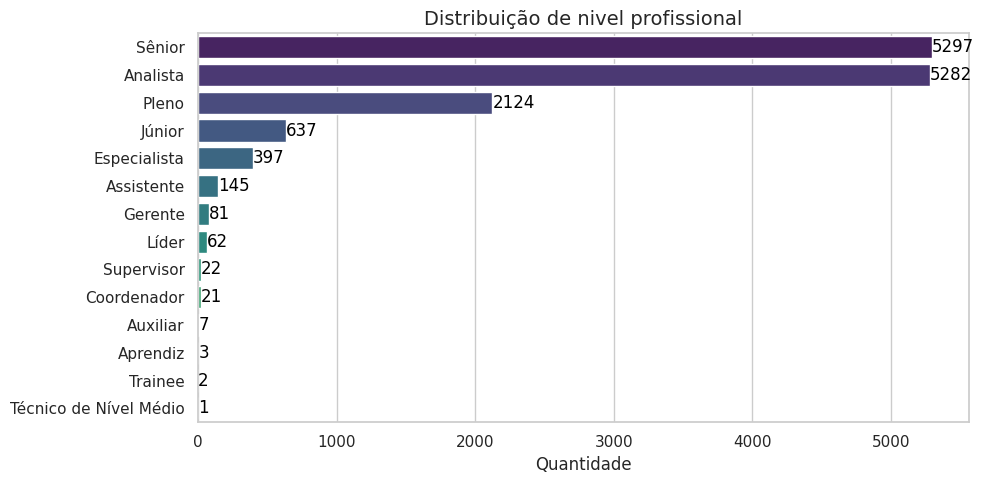

/tmp/ipython-input-2483573260.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette="viridis")


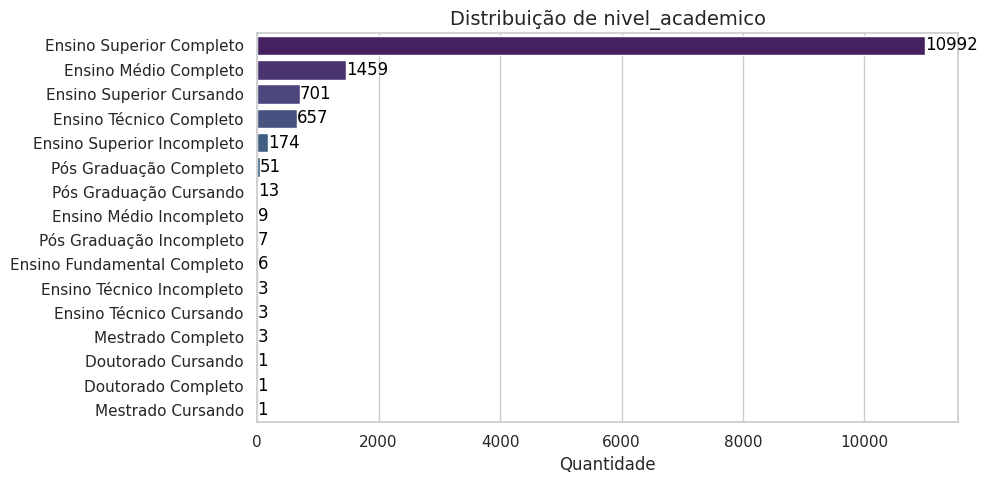

/tmp/ipython-input-2483573260.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette="viridis")


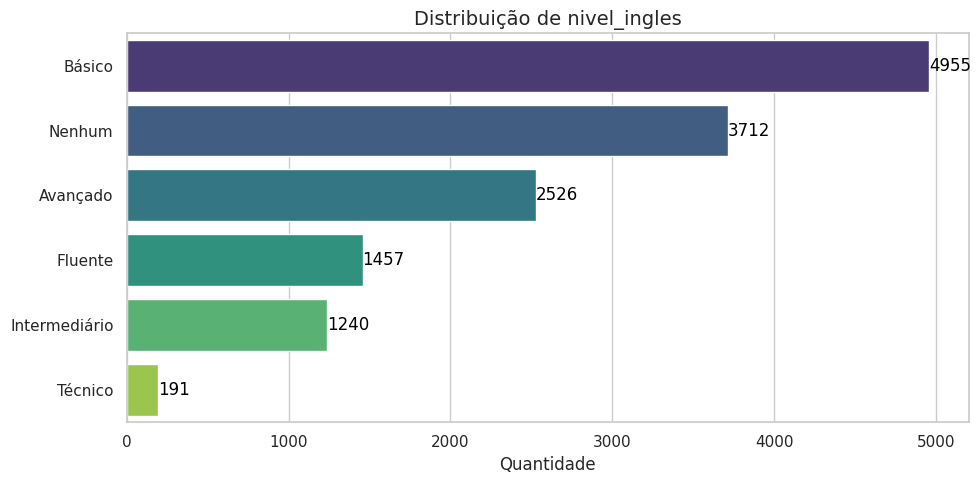

/tmp/ipython-input-2483573260.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette="viridis")


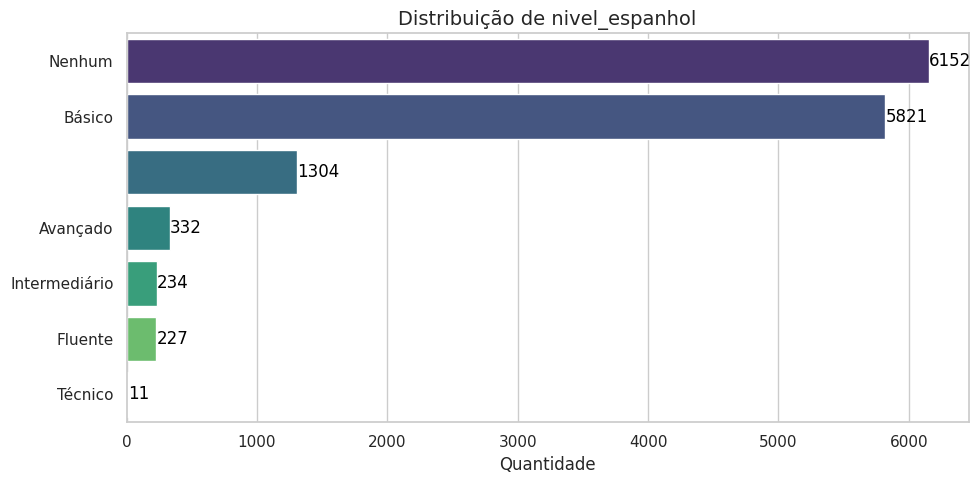

/tmp/ipython-input-2483573260.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette="viridis")


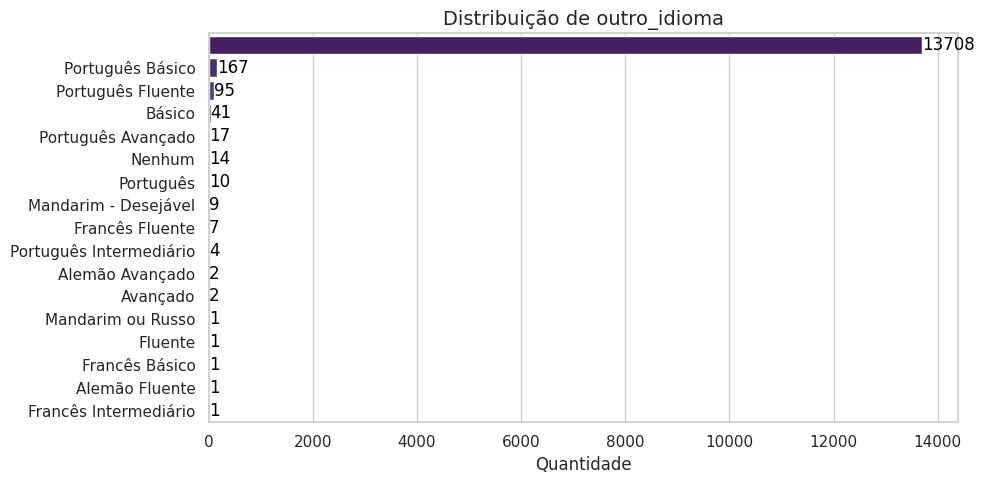

In [9]:
## Visualização da distribuição de atributos das vagas

# Configurações estéticas dos gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

# Colunas categóricas selecionadas para análise
colunas = ['nivel profissional', 'nivel_academico', 'nivel_ingles', 'nivel_espanhol', 'outro_idioma']

# Gera um gráfico de barras para cada coluna
for col in colunas:
    plt.figure()

    # Conta valores únicos (inclui valores nulos)
    counts = df_vagas[col].value_counts(dropna=False)

    # Gráfico de barras
    sns.barplot(x=counts.values, y=counts.index, palette="viridis")

    # Ajustes visuais
    plt.title(f'Distribuição de {col}', fontsize=14)
    plt.xlabel('Quantidade', fontsize=12)
    plt.ylabel('')

    # Adiciona rótulos com os valores no final das barras
    for i, v in enumerate(counts.values):
        plt.text(v + 0.2, i, str(v), color='black', va='center')

    plt.tight_layout()
    plt.show()

Agora que verificamos os valores únicos das colunas, vamos criar um "curriculo" para a criação do modelo

In [10]:
## Função para gerar o "currículo da vaga"

def criar_curriculo_vaga(df_vagas):
    """
    Cria uma nova coluna 'cv_vaga' no DataFrame de vagas.
    Essa coluna contém um texto consolidado e tokenizado com as principais informações da vaga,
    pronto para ser usado em análise de similaridade semântica com currículos de candidatos.

    O texto final é composto por:
    - Nível profissional
    - Nível acadêmico
    - Proficiência em idiomas (inglês, espanhol, outros)
    - Áreas de atuação
    - Principais atividades
    - Competências técnicas e comportamentais
    """

    def montar_lista(row):
        resultado = []

        # Nível profissional
        if pd.notna(row.get('nivel profissional')):
            resultado.append(tokenizar(str(row['nivel profissional'])))

        # Nível acadêmico
        if pd.notna(row.get('nivel_academico')):
            resultado.append(tokenizar(str(row['nivel_academico'])))

        # Inglês
        if pd.notna(row.get('nivel_ingles')) and row['nivel_ingles'] not in ['', 'Nenhum']:
            resultado.append(tokenizar('Inglês ' + str(row['nivel_ingles'])))

        # Espanhol
        if pd.notna(row.get('nivel_espanhol')) and row['nivel_espanhol'] not in ['', 'Nenhum']:
            resultado.append(tokenizar('Espanhol ' + str(row['nivel_espanhol'])))

        # Outro idioma (apenas se houver mais de uma palavra)
        if pd.notna(row.get('outro_idioma')):
            palavras = str(row['outro_idioma']).split()
            if len(palavras) > 1:
                resultado.append(tokenizar(str(row['outro_idioma'])))

        # Áreas de atuação
        if pd.notna(row.get('areas_atuacao')):
            resultado.append(tokenizar(str(row['areas_atuacao'])))

        # Principais atividades e competências
        pa = str(row.get('principais_atividades')) if pd.notna(row.get('principais_atividades')) else ''
        comp = str(row.get('competencia_tecnicas_e_comportamentais')) if pd.notna(row.get('competencia_tecnicas_e_comportamentais')) else ''

        if pa == comp:
            resultado.append(tokenizar(pa))  # se forem iguais, evita duplicação
        else:
            resultado.append(tokenizar(pa))
            resultado.append(tokenizar(comp))

        return ' '.join(resultado)

    # Cria cópia do DataFrame para não alterar o original
    df_vagas = df_vagas.copy()

    # Aplica a função em cada linha do DataFrame
    df_vagas['cv_vaga'] = df_vagas.apply(montar_lista, axis=1)

    return df_vagas

In [11]:
## Carregamento da base de candidatos selecionados

# Lê o JSON de prospects (candidatos selecionados) e redefine o índice
df_prospects = pd.read_json('prospects.json', orient='index').reset_index()
df_prospects.rename(columns={'index': 'id_vaga'}, inplace=True)

# Visualiza as primeiras linhas
df_prospects.head()

,id_vaga,titulo,modalidade,prospects
0,4530,CONSULTOR CONTROL M,,"[{'nome': 'José Vieira', 'codigo': '25632', 's..."
1,4531,2021-2607395-PeopleSoft Application Engine-Dom...,,"[{'nome': 'Sra. Yasmin Fernandes', 'codigo': '..."
2,4532,,,[]
3,4533,2021-2605708-Microfocus Application Life Cycle...,,"[{'nome': 'Arthur Almeida', 'codigo': '26338',..."
4,4534,2021-2605711-Microfocus QTP - UFT Automation T...,,"[{'nome': 'Ana Luiza Vieira', 'codigo': '26361..."


In [12]:
## Seleção de vagas abertas (sem candidatos selecionados)

# Filtra vagas em que a lista de prospects está vazia
vagas_abertas = df_prospects.loc[
    df_prospects["prospects"].apply(lambda x: len(x) == 0 if isinstance(x, (str, list)) else False),
    "id_vaga"
]

# Exibe o número de vagas abertas
print(f"Número de vagas abertas: {len(vagas_abertas)}")

# Mostra as primeiras vagas abertas
vagas_abertas.head()

Número de vagas abertas: 2943


,id_vaga
2,4532
8,4538
9,4539
10,4540
11,4541


In [13]:
## Filtra o DataFrame de vagas para manter apenas as vagas abertas (sem candidatos selecionados)

df_vagas_filtradas = df_vagas[df_vagas["id_vaga"].isin(vagas_abertas)]

# Visualiza as primeiras linhas do DataFrame filtrado
df_vagas_filtradas.head()

,id_vaga,data_requicisao,limite_esperado_para_contratacao,titulo_vaga,vaga_sap,cliente,solicitante_cliente,empresa_divisao,requisitante,analista_responsavel,...,areas_atuacao,principais_atividades,competencia_tecnicas_e_comportamentais,demais_observacoes,viagens_requeridas,equipamentos_necessarios,habilidades_comportamentais_necessarias,valor_venda,valor_compra_1,valor_compra_2
3,5182,04-05-2021,18-05-2021,Technical Architect - 11894809,Não,Nelson-Page,Dr. Raul Monteiro,Decision São Paulo,Cecília Freitas,Clara Rios,...,TI - Projetos-,Descrição/Comentário: Architecture Frameworks ...,Descrição/Comentário: Architecture Frameworks ...,Budgeted Rate - indicate currency and type (ho...,Não,Notebook padrão -,NaN,- p/ mês (168h),fechado,
13,5172,04-05-2021,00-00-0000,System Analyst-WOlks,Não,Barnes-Woods,Maysa Andrade,Decision São Paulo,Vitória Melo,Emanuella Campos,...,TI - SAP-,desc-email,desc-email,,,NaN,NELSON,-,hora,
38,5147,03-05-2021,19-05-2021,Oracle Siebel - 11903896,Não,Nelson-Page,Dr. Raul Monteiro,Decision São Paulo,Cecília Freitas,Dra. Luara Siqueira,...,TI - Projetos-,Descrição/Comentário: Oracle Siebel Communicat...,Descrição/Comentário: Oracle Siebel Communicat...,Budgeted Rate - indicate currency and type (ho...,Não,NaN,Skill Junior,- p/ mês (168h),fechado,
39,5146,03-05-2021,17-05-2021,Java Enterprise Edition - 11896878,Não,Nelson-Page,Dr. Raul Monteiro,Decision São Paulo,Cecília Freitas,Juliana Cassiano,...,TI - Projetos-,"Descrição/Comentário: Java Spring Boot , Conhe...","Descrição/Comentário: Java Spring Boot , Conhe...",,Não,Notebook padrão -,NaN,- p/ mês (168h),fechado,
42,5143,03-05-2021,17-05-2021,Salesforce / Desenvolvedor Júnior - 11901576,Não,Nelson-Page,Dr. Raul Monteiro,Decision São Paulo,Cecília Freitas,Dra. Luara Siqueira,...,TI - Projetos-,Descrição/Comentário: Configuration & Release ...,Descrição/Comentário: Configuration & Release ...,,Não,Notebook padrão -,NaN,- p/ mês (168h),fechado,


In [14]:
## Cria a coluna 'cv_vaga' com o currículo da vaga e armazena em novo DataFrame

# Aplica a função para gerar o "currículo da vaga"
df_vagas_filtradas = criar_curriculo_vaga(df_vagas_filtradas)

# Cria um DataFrame separado com os currículos das vagas
df_vagas_curriculo = df_vagas_filtradas

# Visualiza as primeiras linhas
df_vagas_curriculo.head()

,id_vaga,data_requicisao,limite_esperado_para_contratacao,titulo_vaga,vaga_sap,cliente,solicitante_cliente,empresa_divisao,requisitante,analista_responsavel,...,principais_atividades,competencia_tecnicas_e_comportamentais,demais_observacoes,viagens_requeridas,equipamentos_necessarios,habilidades_comportamentais_necessarias,valor_venda,valor_compra_1,valor_compra_2,cv_vaga
3,5182,04-05-2021,18-05-2021,Technical Architect - 11894809,Não,Nelson-Page,Dr. Raul Monteiro,Decision São Paulo,Cecília Freitas,Clara Rios,...,Descrição/Comentário: Architecture Frameworks ...,Descrição/Comentário: Architecture Frameworks ...,Budgeted Rate - indicate currency and type (ho...,Não,Notebook padrão -,NaN,- p/ mês (168h),fechado,,analista ensino superior completo ingles basic...
13,5172,04-05-2021,00-00-0000,System Analyst-WOlks,Não,Barnes-Woods,Maysa Andrade,Decision São Paulo,Vitória Melo,Emanuella Campos,...,desc-email,desc-email,,,NaN,NELSON,-,hora,,senior ensino medio completo espanhol fluente ...
38,5147,03-05-2021,19-05-2021,Oracle Siebel - 11903896,Não,Nelson-Page,Dr. Raul Monteiro,Decision São Paulo,Cecília Freitas,Dra. Luara Siqueira,...,Descrição/Comentário: Oracle Siebel Communicat...,Descrição/Comentário: Oracle Siebel Communicat...,Budgeted Rate - indicate currency and type (ho...,Não,NaN,Skill Junior,- p/ mês (168h),fechado,,analista ensino superior completo ingles basic...
39,5146,03-05-2021,17-05-2021,Java Enterprise Edition - 11896878,Não,Nelson-Page,Dr. Raul Monteiro,Decision São Paulo,Cecília Freitas,Juliana Cassiano,...,"Descrição/Comentário: Java Spring Boot , Conhe...","Descrição/Comentário: Java Spring Boot , Conhe...",,Não,Notebook padrão -,NaN,- p/ mês (168h),fechado,,analista ensino superior completo ingles basic...
42,5143,03-05-2021,17-05-2021,Salesforce / Desenvolvedor Júnior - 11901576,Não,Nelson-Page,Dr. Raul Monteiro,Decision São Paulo,Cecília Freitas,Dra. Luara Siqueira,...,Descrição/Comentário: Configuration & Release ...,Descrição/Comentário: Configuration & Release ...,,Não,Notebook padrão -,NaN,- p/ mês (168h),fechado,,analista ensino superior completo ingles basic...


In [25]:
## Visualiza o currículo tokenizado da quarta vaga no DataFrame (índice 3)
df_vagas_curriculo.iloc[3]['cv_vaga']

'analista ensino superior completo ingles basico espanhol basico ti projeto descricao comentario jar Spring boot conhecimento arquitetura aplicacoes banco dado Oracle rest capacidade lideranca tecnico time primary skill jar enterprise edition'

In [16]:
## Função para fixar seeds e garantir reprodutibilidade
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Seleção de Modelo

## Justificativa da Escolha

Neste projeto, o objetivo é avaliar a aderência de um candidato às vagas abertas com base nas descrições da vagas abertas. Para isso, utilizamos **Sentence-BERT (`all-MiniLM-L6-v2`)** devido a:

1. **Capacidade de Capturar Semântica**  
   - Modelos tradicionais (Bag-of-Words, TF-IDF) ignoram contexto.  
   - Sentence-BERT gera embeddings semânticos, aproximando textos com significados similares, mesmo com palavras diferentes.

2. **Eficiência e Escalabilidade**  
   - `all-MiniLM-L6-v2` é leve e rápido, adequado para milhares de vagas/currículos.  
   - Funciona bem em CPU ou GPU.

3. **Flexibilidade**  
   - Permite calcular similaridade entre qualquer par de textos (currículo ↔ vaga).  
  

In [17]:
## Função para treinar um recomendador de vagas usando Sentence-BERT

def treinar_recomendador(df_vagas, modelo_name="all-MiniLM-L6-v2", seed=42):
    """
    Treina um modelo de recomendação robusto usando Sentence-BERT.

    Parâmetros:
    - df_vagas: DataFrame com coluna 'cv_vaga' contendo textos pré-processados.
    - modelo_name: nome do modelo SentenceTransformer (padrão: all-MiniLM-L6-v2)
    - seed: semente para reprodutibilidade

    Retorna:
    - model: modelo SentenceTransformer carregado
    - embeddings_vagas: embeddings das vagas, prontos para cálculo de similaridade
    """
    # Define a seed para reprodutibilidade
    set_seed(seed)

    # Carrega o modelo pré-treinado
    model = SentenceTransformer(modelo_name)

    # Gera embeddings das vagas
    embeddings_vagas = model.encode(df_vagas['cv_vaga'].tolist(), convert_to_tensor=True)

    return model, embeddings_vagas

## Métricas de Avaliação

- **Similaridade semântica (cosine similarity)**: base do ranking de aderência.  
- **Avaliação qualitativa**: conferência manual das recomendações.  

In [18]:
## Função para recomendar vagas com base no currículo do candidato

def recomendar_vagas(cv_candidato, df_vagas, model, embeddings_vagas, limiar=0.7):
    """
    Recebe o currículo do candidato (cv_candidato), calcula a similaridade com os currículos
    das vagas e retorna apenas aquelas com aderência acima do limiar especificado.

    Retorna um DataFrame contendo:
    - id_vaga
    - titulo_vaga
    - similaridade com o candidato
    """
    # Gera embedding do candidato
    embedding_candidato = model.encode(cv_candidato, convert_to_tensor=True)

    # Calcula similaridade coseno entre candidato e vagas
    cosine_scores = util.cos_sim(embedding_candidato, embeddings_vagas)[0].cpu().numpy()

    # Filtra vagas com similaridade acima do limiar
    idx_filtrados = np.where(cosine_scores >= limiar)[0]

    # Cria DataFrame com resultados e adiciona coluna de similaridade
    df_result = df_vagas.iloc[idx_filtrados].copy()
    df_result['similaridade'] = cosine_scores[idx_filtrados]

    # Ordena do mais aderente para o menos aderente
    df_result = df_result.sort_values(by='similaridade', ascending=False)

    return df_result[['id_vaga', 'titulo_vaga', 'similaridade']]

In [19]:
## Treinamento do modelo de recomendação de vagas e geração dos embeddings
model, embeddings_vagas = treinar_recomendador(df_vagas_curriculo, seed=SEED)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Interpretabilidade

- Embeddings não são diretamente interpretáveis, mas a **similaridade coseno é intuitiva**:
  - Scores próximos de 1 → forte aderência.
  - Scores próximos de 0 → baixa compatibilidade.  

In [30]:
## Validação do modelo: recomenda vagas para o candidato no indice 1

# Seleciona e tokeniza o currículo do candidato
cv_candidato = df['cv_pt'].iloc[1]
cv_candidato = tokenizar(cv_candidato)

# Obtém vagas recomendadas com base na similaridade semântica
vagas_recomendadas = recomendar_vagas(
    cv_candidato=cv_candidato,
    df_vagas=df_vagas_curriculo,
    model=model,
    embeddings_vagas=embeddings_vagas,
    limiar=0.7
)

# Exibe o currículo do candidato
print(f"Currículo do Candidato: {cv_candidato}")

# Exibe as vagas recomendadas e a aderência em porcentagem
for idx, row in vagas_recomendadas.iterrows():
    aderencia = row['similaridade'] * 100
    print(f"Vaga: {row['titulo_vaga']} (ID: {row['id_vaga']}) - Aderência: {aderencia:.2f}%")

Currículo do Candidato: formacao academicar ensino medio 2o grau ensino medio 2o grau beatriz Lopes sp jan 2010 ate dez 2012 ensino superior administracao empresa unip sp jun 2016 trancar experiencia profissional analista administrativo operacoe liqr sao Paulo sp mai 2018 ate momento administracao administracao geral analista auxiliar em o area bi Business intelligence extracao informacao analise relatorio gerencial acompanhamento de o processo area financeiro rh operacional suporte todo areo backoffice suporte todo supervisor criacao indicador dashboard por o excel analista operacoe trade todo suporte equipe supervisor gerente estagiario ballmash moda confeccoes ltda eireli epp sp jan 2017 ate nov 2017 administracao administracao geral estagiario atividade administracao geral auxilio em o conferencia de o caixa controle venda em o cartao lancamento dado planilha contas pagar emissao lancamento nota fiscal auxiliar em o arquivo documento atendimento telefonico anotacoes atendimento a o

In [38]:
# Verificando o curriculo da vaga com maior aderencia
curriculos_vaga = df_vagas_curriculo[df_vagas_curriculo['id_vaga'] == 10487]['cv_vaga'].iloc[0]

# Mostra o resultado
print(curriculos_vaga)

analista ensino superior completo ingles intermediario espanhol fluente ti projeto finance strategy executar processo contabel geral alto completo financo ciencia contabel administracao area relacionar realizar analise registro contabel em o erp sap devido registro contabel contabilidade tesourarer suporte a o fechamento contabil mensal junto contabilidade contabilidade tesourarer realizar fluxo Caixa projetar realizar aplicacao emprestimo controle endividamento conciliacao bancario tesourario habilidade em o pacote office conhecimento avancar excel procv somase formatacao dar avancar relatorio tabela grafico dinamico hora 8 00am to 5 00pm 1 cost accounting p3 advanced 2 finance Processes and systems p3 advanced 3 revenuir analytics p3 advanced 4 shareholder value Analysis p3 advanced 1 spanish c1 expert primary skill others please note the skill at the Beginning of job descriptionr


In [21]:
## Currículo de teste para validação do modelo (Engenheiro de Software Sênior) - Gerado pelo chatgpt
cv_teste = '''Nome: João Silva
Cargo Desejado: Engenheiro de Software Sênior

Resumo Profissional:
Engenheiro de Software com 8 anos de experiência em desenvolvimento backend e arquitetura de sistemas. Forte habilidade em análise de requisitos, design de software e gestão de projetos.

Experiência Profissional:
- Empresa: Tech Solutions
  Cargo: Engenheiro de Software Sênior
  Período: Jan/2018 – Atual
  Principais Atividades:
    - Desenvolvimento de APIs em Python e Java.
    - Implementação de pipelines de dados e integração com bancos SQL e NoSQL.
    - Mentoria de desenvolvedores juniores e mediação de code reviews.
    - Participação na definição de arquitetura de sistemas de alta escala.

- Empresa: Innovatech
  Cargo: Engenheiro de Software
  Período: Fev/2015 – Dez/2017
  Principais Atividades:
    - Desenvolvimento de soluções web com Django e Flask.
    - Criação de testes automatizados e melhoria de performance de aplicações.
    - Participação em squads ágeis para entrega de novas funcionalidades.

Formação Acadêmica:
- Bacharel em Ciência da Computação – Universidade XYZ (2010 – 2014)

Idiomas:
- Inglês Avançado
- Espanhol Intermediário

Competências Técnicas:
- Linguagens: Python, Java, SQL
- Frameworks: Django, Flask, Spring
- Ferramentas: Git, Docker, Kubernetes
- Metodologias Ágeis: Scrum, Kanban
'''

In [31]:
## Validação do modelo com currículo fictício (Engenheiro de Software)

# Tokeniza o currículo de teste
cv_candidato = tokenizar(cv_teste)

# Obtém vagas recomendadas com base na similaridade semântica
vagas_recomendadas = recomendar_vagas(
    cv_candidato=cv_candidato,
    df_vagas=df_vagas_curriculo,
    model=model,
    embeddings_vagas=embeddings_vagas,
    limiar=0.7
)

# Exibe o currículo do candidato
print(f"Currículo do Candidato: {cv_candidato}")

# Exibe as vagas recomendadas e a aderência em porcentagem
for idx, row in vagas_recomendadas.iterrows():
    aderencia = row['similaridade'] * 100
    print(f"Vaga: {row['titulo_vaga']} (ID: {row['id_vaga']}) - Aderência: {aderencia:.2f}%")

Currículo do Candidato: nome joao Silva cargo desejar engenheiro software senior resumo profissional engenheiro software 8 ano experiencia desenvolvimento backend arquitetura sistema forte habilidade analise requisito design software gestao projeto experiencia profissional empresa tech solutions cargo engenheiro software senior periodo jan 2018 atual principal atividade desenvolvimento apis python jar implementacao pipeline dado integracao banco sql nosql mentorio desenvolvedor juniores Mediacao code reviews participacao em o definicao arquitetura sistema alta escala empresa Innovatech cargo engenheiro software periodo fev 2015 dez 2017 principal atividade desenvolvimento solucoes web django flask criacao teste automatizar melhoria performance aplicacoes participacao squads ageis entrega novo funcionalidade formacao academicar bacharel ciencia de o computacao universidade xyz 2010 2014 idioma ingles avancar espanhol intermediario competencio tecnico linguagem python jar sql frameworks 

In [39]:
# Verificando o curriculo da vaga com maior aderencia
curriculos_vaga = df_vagas_curriculo[df_vagas_curriculo['id_vaga'] == 13189]['cv_vaga'].iloc[0]

# Mostra o resultado
print(curriculos_vaga)

senior ensino superior completo ingle avancar espanhol basico ti projeto periodo 6 mês possibilidade renovacao 100 home office ingles avancar conversacao atribuicoe vivencer desenvolver manter aplicativo utilizar c scripts python colaborar equipe multidisciplinar definir projetar entregar novo funcionalidade integrar sistema servico utilizar apis restful outro tecnologia trabalhar banco dado mongo sql otimizar desempenho aplicativo solucoes garantir escalabilidade realizar teste unidade integracao participar revisoes codigo garantir qualidade de o codigo atrave de o bom pratica desenvolvimento requisitos experiencia comprovar trabalho desenvolvedor c python forte experiencia frameworks biblioteca c net core python numpy panr experiencia desenvolvimento apis restful experiencia integracao servico nuvir preferencialmente azurar familiaridade uso controle versao Git metodologia desenvolvimento agil excelente habilidade resolucao problema comunicacao


# Como Melhorar os Resultados do Modelo

Para aumentar a precisão das recomendações, algumas ações podem ser realizadas:

1. **Melhorar a Qualidade dos Dados de Vagas**  
   - Alinhar com o RH para solicitar aos gestores **descrições mais detalhadas** nos campos:
     - `competencia_tecnicas_e_comportamentais`
     - `principais_atividades`
   - Quanto mais completas e consistentes forem essas informações, melhor o modelo consegue capturar as competências e responsabilidades de cada vaga.

2. **Padronização dos Termos**  
   - Incentivar o uso de termos padronizados para competências, áreas de atuação e níveis de proficiência.  
   - Isso reduz ambiguidades e melhora a correspondência semântica entre currículos e vagas.

3. **Revisão Contínua do Modelo**  
   - Monitorar as recomendações com feedback do RH.  
   - Ajustar limiar de similaridade (`limiar`) e atualizar embeddings periodicamente para refletir mudanças nas vagas e perfis dos candidatos.



In [32]:
## Salvando o modelo, embeddings e DataFrame de vagas para uso futuro

# Salva o modelo treinado
model_save_path = "modelo_recomendador"
model.save(model_save_path)

# Salva os embeddings das vagas em arquivo binário
with open("embeddings_vagas.pkl", "wb") as f:
    pickle.dump(embeddings_vagas, f)

# Salva o DataFrame de vagas com currículos tokenizados
df_vagas_curriculo.to_csv("vagas_curriculo.csv", index=False)

print("Modelo e embeddings salvos com sucesso!")

Modelo e embeddings salvos com sucesso!


In [33]:
## Compacta a pasta do modelo em um arquivo ZIP para download

import shutil

# Nome da pasta do modelo
pasta = "modelo_recomendador"

# Nome do arquivo ZIP que será criado
zip_file = "modelo_recomendador.zip"

# Cria o arquivo ZIP da pasta
shutil.make_archive("modelo_recomendador", 'zip', pasta)


'/content/modelo_recomendador.zip'